In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# GSoC 2025 DeepLense - Common Test I: Multi-Class Classification
*   **Author:** Bryan Chen
*   **Date:** September 28, 2025

## 0. Introduction

**Objective:** This notebook addresses the Common Test I for the DeepLense GSoC project. The goal is to build a robust deep learning model to classify strong gravitational lensing images into three distinct categories:
1.  `no`: Images without significant dark matter substructure.
2.  `sphere`: Images with spherical (subhalo-type) dark matter substructures.
3.  `vort`: Images with vortex-like dark matter substructures.

**Methodology:** Our approach is structured to be clear, reproducible, and thorough:
1.  **Setup & Configuration:** Import libraries and define key parameters in a centralized configuration class.
2.  **Exploratory Data Analysis (EDA):** A deep dive into the dataset to understand its structure, class balance, image properties, and pixel distributions. This critical step informs our modeling choices.
3.  **Data Processing & Augmentation:** Create an efficient and robust data loading pipeline using PyTorch's `Dataset` and `DataLoader`, incorporating data augmentation to improve model generalization.
4.  **Model Architecture:** Select a proven convolutional neural network (CNN) architecture (ResNet-18) and adapt it for this specific single-channel image classification task.
5.  **Training Pipeline:** Define the loss function, optimizer, and a learning rate scheduler to train the model effectively and prevent overfitting.
6.  **Model Training & Validation:** Train the model while monitoring its performance on a validation set, saving the best-performing version based on validation loss.
7.  **Evaluation:** Thoroughly evaluate the final model using the required metrics, including accuracy, class-specific ROC curves, AUC scores, and a confusion matrix for a granular performance analysis.
8.  **Conclusion:** Summarize the results and discuss the model's performance.


## 1. Setup and Configuration

First, let's install the necessary libraries and set up our environment.

In [2]:
!pip install timm torchsummary -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.3 MB/s eta 0:00:00:00:0100:01


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from torchsummary import summary
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix

In [4]:
# Centralized configuration for easy adjustments
class Config:
    # --- IMPORTANT: CHANGE THIS TO YOUR KAGGLE DATASET PATH ---
    BASE_DIR = '/kaggle/input/gsoc-deeplense-classification-data/dataset'
    
    # Paths
    TRAIN_DIR = os.path.join(BASE_DIR, 'train')
    VAL_DIR = os.path.join(BASE_DIR, 'val')
    OUTPUT_DIR = '/kaggle/working/' # Directory to save models

    # Model
    MODEL_NAME = 'resnet18'
    PRETRAINED = True
    NUM_CLASSES = 3
    IN_CHANS = 1 # Grayscale images

    # Training
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 64
    EPOCHS = 15 # Increased epochs for better convergence
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-4

    # Class mapping
    CLASS_MAP = {"no": 0, "sphere": 1, "vort": 2}
    INV_CLASS_MAP = {v: k for k, v in CLASS_MAP.items()}

In [5]:
# Create output directory if it doesn't exist
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

print(f"Using device: {Config.DEVICE}")
print(f"Train directory exists: {os.path.exists(Config.TRAIN_DIR)}")
print(f"Validation directory exists: {os.path.exists(Config.VAL_DIR)}")

Using device: cuda
Train directory exists: True
Validation directory exists: True


## 2. Exploratory Data Analysis (EDA)

Before building any model, a deep understanding of the data is essential.

### 2.1. Dataset Overview & Class Balance

Let's load the file paths and check the number of images per class to ensure the dataset is balanced.

In [6]:
def get_file_paths_and_labels(root_dir):
    """Scans a directory and returns a DataFrame of file paths and class names."""
    paths = []
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.npy'):
                    paths.append((os.path.join(class_dir, file_name), class_name))
    return pd.DataFrame(paths, columns=['filepath', 'class_name'])

train_df = get_file_paths_and_labels(Config.TRAIN_DIR)
val_df = get_file_paths_and_labels(Config.VAL_DIR)

print("--- Training Set Analysis ---")
print(f"Total training images: {len(train_df)}")
print("Class distribution:\n", train_df['class_name'].value_counts())
print("\n--- Validation Set Analysis ---")
print(f"Total validation images: {len(val_df)}")
print("Class distribution:\n", val_df['class_name'].value_counts())

--- Training Set Analysis ---
Total training images: 30000
Class distribution:
 class_name
no        10000
vort      10000
sphere    10000
Name: count, dtype: int64

--- Validation Set Analysis ---
Total validation images: 7500
Class distribution:
 class_name
no        2500
vort      2500
sphere    2500
Name: count, dtype: int64


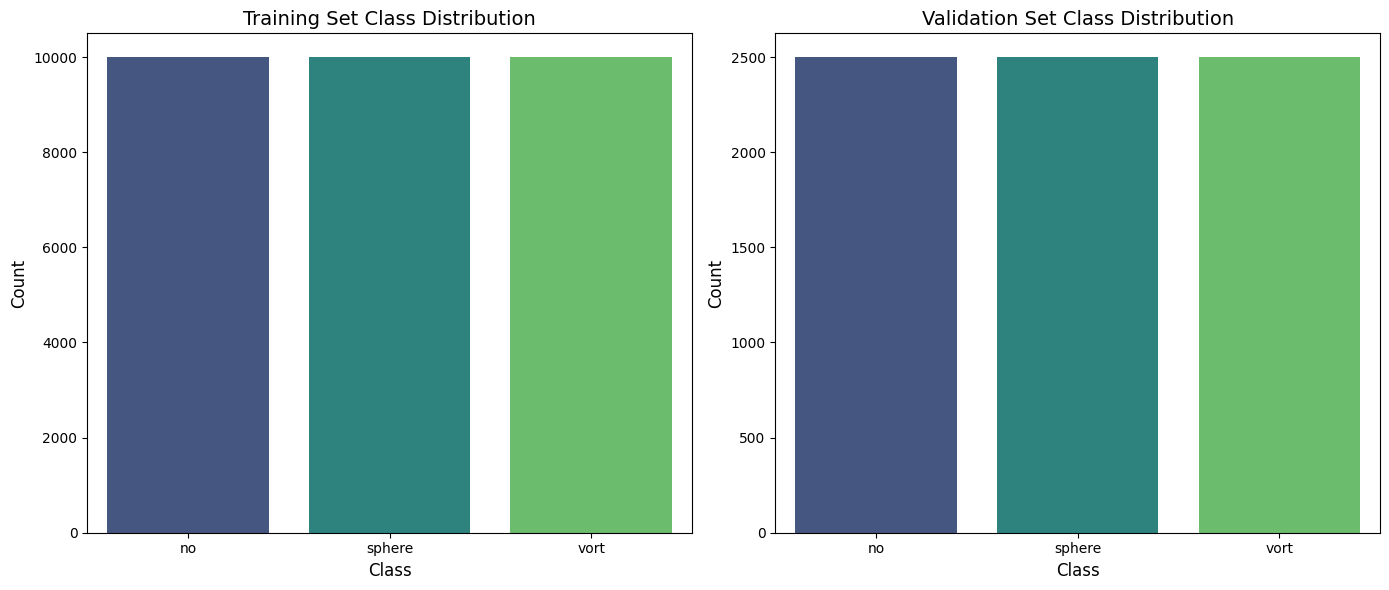

In [7]:
# Visualize class distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='class_name', order=Config.CLASS_MAP.keys(), palette='viridis')
plt.title('Training Set Class Distribution', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)

plt.subplot(1, 2, 2)
sns.countplot(data=val_df, x='class_name', order=Config.CLASS_MAP.keys(), palette='viridis')
plt.title('Validation Set Class Distribution', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)

plt.tight_layout()
plt.show()


### 2.2. Image Shape and Content

Let's load a sample image from each class to inspect its dimensions and visualize the lensing patterns.

In [8]:
# Load a sample to check its shape
sample_path = train_df['filepath'].iloc[0]
sample_image = np.load(sample_path)
print(f"Raw image shape from .npy file: {sample_image.shape}")
# The shape is (1, 150, 150), indicating a single channel (grayscale) image. We will need to handle this.

Raw image shape from .npy file: (1, 150, 150)


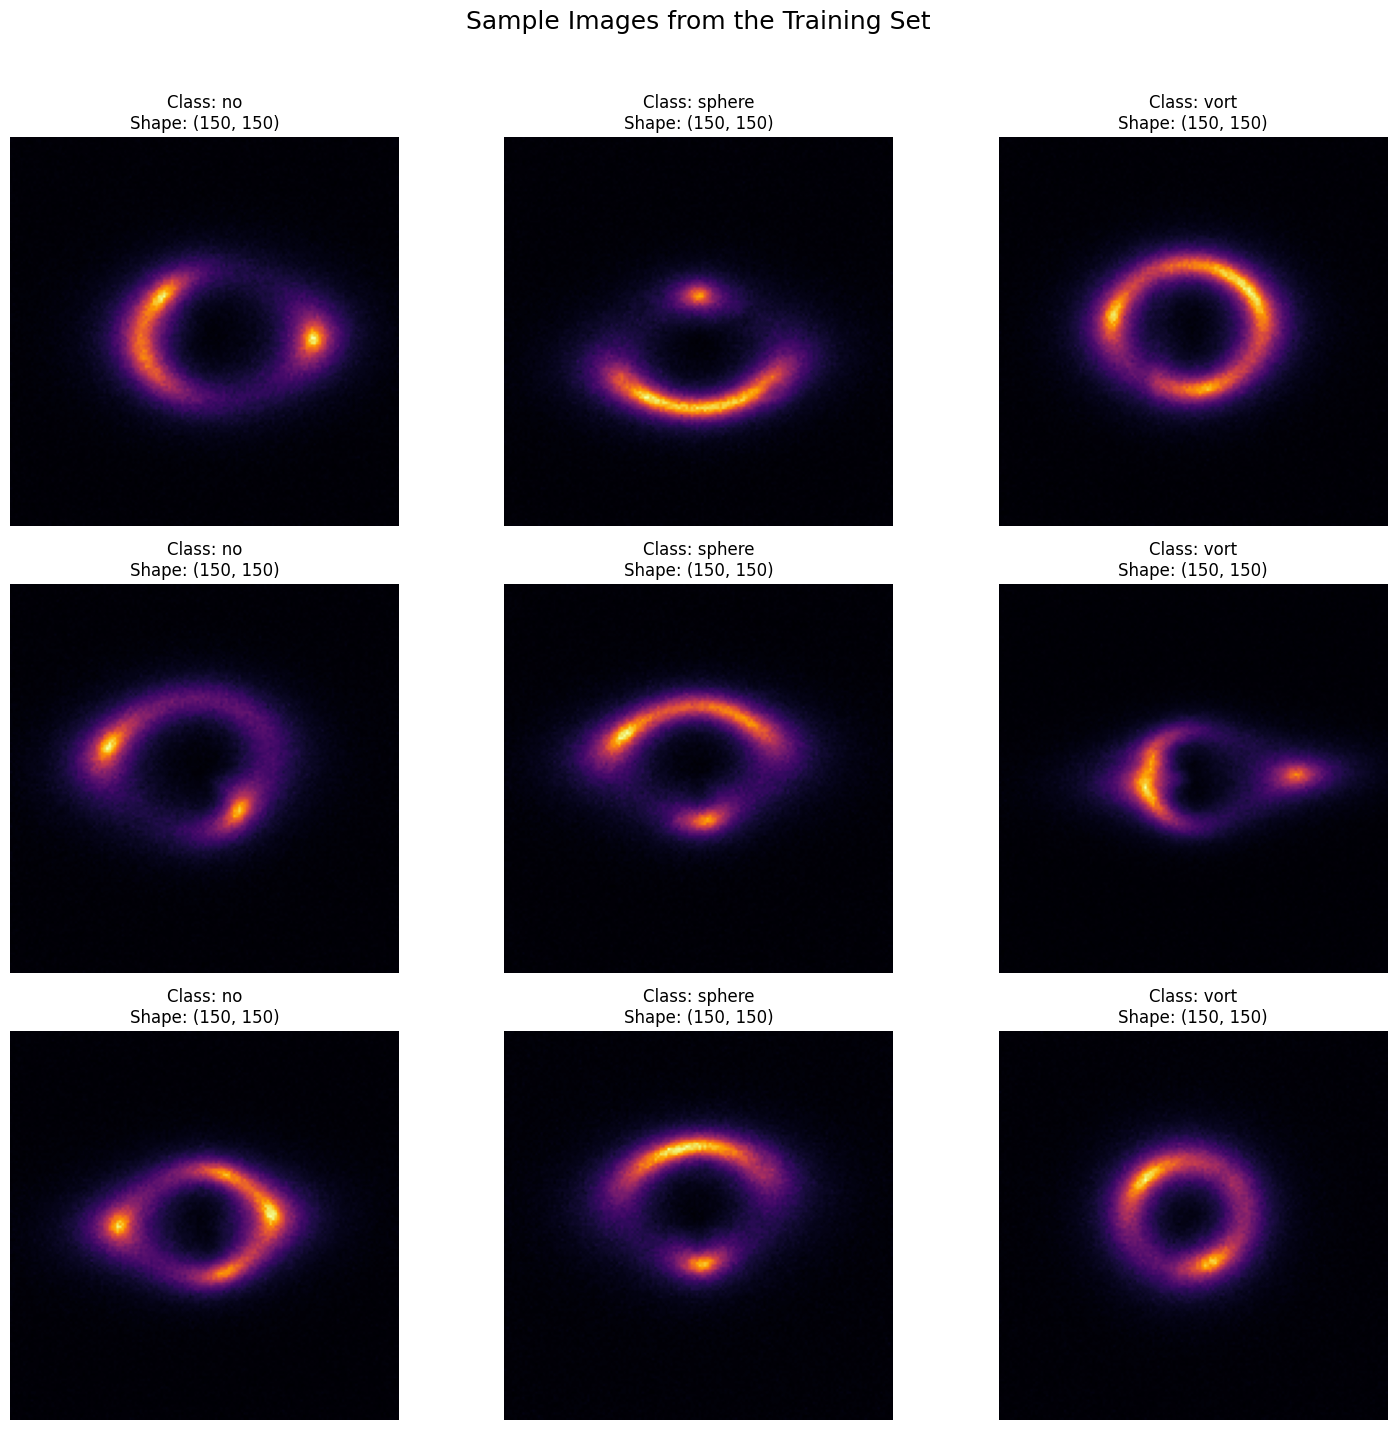

In [21]:
def show_sample_images(df, title, n_samples=3):
    """Displays n_samples from each class."""
    plt.figure(figsize=(15, 5 * n_samples))
    
    for i, class_name in enumerate(Config.CLASS_MAP.keys()):
        sample_df = df[df['class_name'] == class_name].sample(n_samples)
        for j, (_, row) in enumerate(sample_df.iterrows()):
            ax_idx = j * len(Config.CLASS_MAP.keys()) + i + 1
            image_data = np.load(row['filepath'])
            image_data = np.squeeze(image_data) # Remove the channel dimension for plotting

            plt.subplot(n_samples, len(Config.CLASS_MAP.keys()), ax_idx)
            plt.imshow(image_data, cmap='inferno')
            plt.title(f'Class: {class_name}\nShape: {image_data.shape}')
            plt.axis('off')
            
    plt.suptitle(title, fontsize=18, y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

show_sample_images(train_df, "Sample Images from the Training Set")

### 2.3. Pixel Intensity Distribution

Analyzing the pixel value distribution helps in choosing the right normalization strategy.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


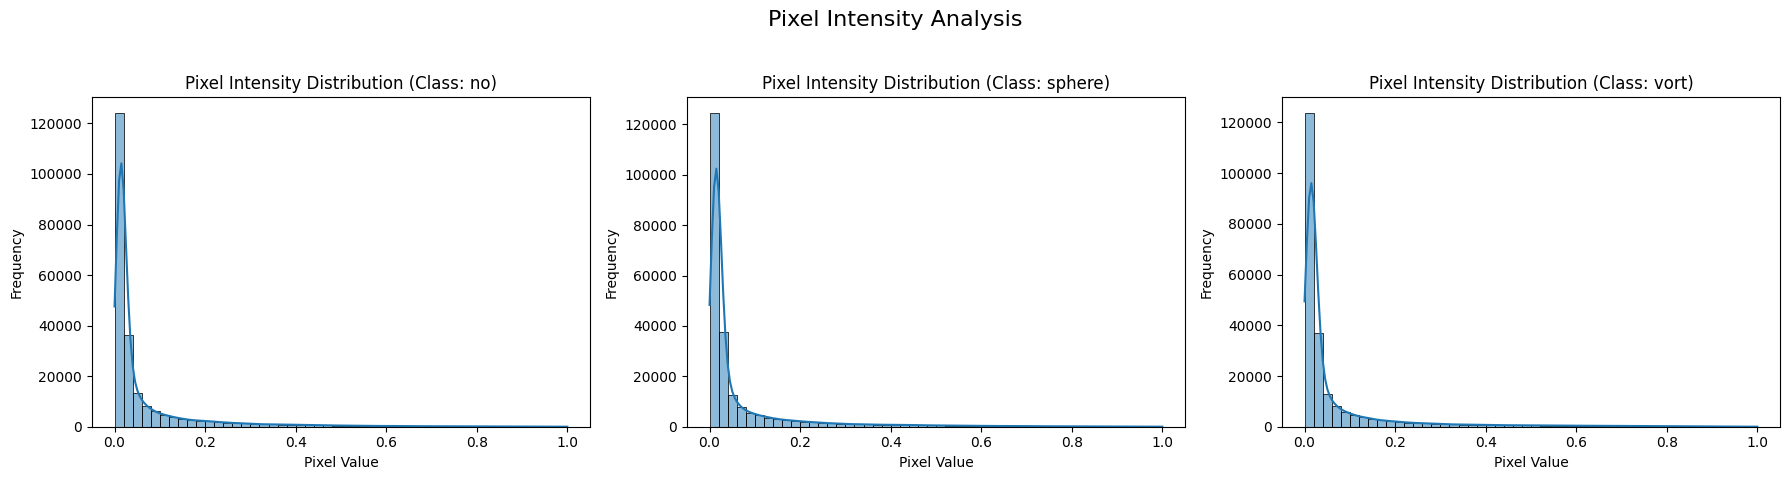

In [10]:
plt.figure(figsize=(18, 5))
for i, class_name in enumerate(Config.CLASS_MAP.keys()):
    # Aggregate data from a few images for a representative distribution
    sample_paths = train_df[train_df['class_name'] == class_name].sample(10)['filepath']
    pixel_data = np.concatenate([np.load(p).flatten() for p in sample_paths])

    plt.subplot(1, 3, i + 1)
    sns.histplot(pixel_data, bins=50, kde=True)
    plt.title(f'Pixel Intensity Distribution (Class: {class_name})')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
plt.suptitle('Pixel Intensity Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### EDA Conclusion:
1.  **Dataset is Balanced:** The number of images for each of the three classes is almost identical in both training and validation sets. This is ideal, as it prevents the model from being biased towards a majority class.
2.  **Image Shape:** The images are single-channel (grayscale) with a shape of `(1, 150, 150)`. We will need to configure our model to accept a single input channel.
3.  **Visual Patterns:** The classes are visually distinct. 'no' substructure images show smooth, clean arcs. 'sphere' and 'vort' classes exhibit more distorted, noisy, or complex patterns, which a CNN should be able to learn.
4.  **Pixel Distribution:** The pixel values are already normalized (likely min-max), concentrated between 0 and 1. We will still apply a standard normalization `(mean=0.5, std=0.5)` to center the data around zero, which is a common practice that aids model training.

## 3. Data Processing and Augmentation

We'll create a custom PyTorch `Dataset`. Data augmentation (random flips, rotations) will be applied to the training set to help the model generalize better and prevent overfitting.

In [11]:
class LensingDataset(Dataset):
    """Custom PyTorch Dataset for loading lensing images."""
    def __init__(self, df, transform=None):
        self.df = df
        self.filepaths = df['filepath'].values
        self.labels = df['class_name'].map(Config.CLASS_MAP).values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        # Load image and ensure it's float32
        # The raw shape is (1, 150, 150), which is what ToTensor() expects for a single-channel image.
        image = np.load(filepath).astype(np.float32)
        label = self.labels[idx]

        if self.transform:
            # Our transforms expect a (C, H, W) tensor, so we apply them here.
            # ToTensor() will convert (C, H, W) numpy array to (C, H, W) tensor.
            image = self.transform(torch.from_numpy(image))
        else:
            image = torch.from_numpy(image)

        return image, torch.tensor(label, dtype=torch.long)

In [12]:
# Define transformations. Augmentation is only for the training set.
data_transforms = {
    'train': transforms.Compose([
        # ToTensor() is not needed here as we convert to tensor in __getitem__
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=20),
        transforms.Normalize(mean=[0.5], std=[0.5]) # Normalizing for a single channel
    ]),
    'val': transforms.Compose([
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
}

# Create datasets
train_dataset = LensingDataset(train_df, transform=data_transforms['train'])
val_dataset = LensingDataset(val_df, transform=data_transforms['val'])

# Create dataloaders
# Using num_workers > 0 speeds up data loading on Kaggle
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"DataLoaders created.")
print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

DataLoaders created.
Training batches: 469, Validation batches: 118


## 4. Model Architecture

We will use a ResNet-18 model from the `timm` library, pre-trained on ImageNet. We must adapt it for our problem:
1.  Modify the first convolutional layer to accept 1-channel (grayscale) images instead of 3-channel (RGB).
2.  Modify the final fully-connected layer to output 3 class scores.


In [13]:
def create_model():
    """Creates and configures the model for our specific task."""
    model = timm.create_model(
        Config.MODEL_NAME,
        pretrained=Config.PRETRAINED,
        num_classes=Config.NUM_CLASSES,
        in_chans=Config.IN_CHANS
    )
    return model.to(Config.DEVICE)

model = create_model()

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [14]:
# Print a summary of the model architecture
summary(model, input_size=(Config.IN_CHANS, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           3,136
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]          36,864
       BatchNorm2d-6           [-1, 64, 38, 38]             128
          Identity-7           [-1, 64, 38, 38]               0
              ReLU-8           [-1, 64, 38, 38]               0
          Identity-9           [-1, 64, 38, 38]               0
           Conv2d-10           [-1, 64, 38, 38]          36,864
      BatchNorm2d-11           [-1, 64, 38, 38]             128
             ReLU-12           [-1, 64, 38, 38]               0
       BasicBlock-13           [-1, 64, 38, 38]               0
           Conv2d-14           [-1, 64,

## 5. Training Pipeline Setup

We'll define our loss function, optimizer, and a learning rate scheduler.

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)

# OneCycleLR is a modern scheduler that often leads to faster convergence and better performance.
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=Config.LEARNING_RATE,
    steps_per_epoch=len(train_loader),
    epochs=Config.EPOCHS
)

## 6. Model Training & Validation

Now we'll loop through epochs, training the model and validating its performance. We will save the model with the lowest validation loss.

In [ ]:
def plot_roc_per_epoch(y_true, y_scores, epoch):
    y_true_binarized = np.eye(Config.NUM_CLASSES)[y_true]
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(Config.NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    macro_roc_auc = roc_auc_score(y_true, y_scores, multi_class='ovr', average='macro')

    plt.figure(figsize=(8, 6))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for i, color in zip(range(Config.NUM_CLASSES), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {Config.INV_CLASS_MAP[i]} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Epoch {epoch} (Macro AUC = {macro_roc_auc:.4f})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [16]:
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_auc': []}
best_val_loss = float('inf')

for epoch in range(Config.EPOCHS):
    # --- Training Phase ---
    model.train()
    train_loss = 0.0
    
    pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS} [Train]")
    for inputs, labels in pbar_train:
        inputs, labels = inputs.to(Config.DEVICE), labels.to(Config.DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step() # Step scheduler at each iteration for OneCycleLR

        train_loss += loss.item()
        pbar_train.set_postfix(loss=loss.item(), lr=scheduler.get_last_lr()[0])

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct_preds = 0

    y_true_epoch = []
    y_scores_epoch = []
    
    pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS} [Val]")
    with torch.no_grad():
        for inputs, labels in pbar_val:
            inputs, labels = inputs.to(Config.DEVICE), labels.to(Config.DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = torch.nn.functional.softmax(outputs, dim=1)
            y_scores_epoch.extend(probs.cpu().numpy())
            y_true_epoch.extend(labels.cpu().numpy())

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)

    # Calculate average losses and accuracy
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_preds.double() / len(val_dataset)

    y_true_epoch = np.array(y_true_epoch)
    y_scores_epoch = np.array(y_scores_epoch)
    plot_roc_per_epoch(y_true_epoch, y_scores_epoch, epoch + 1)
    val_auc = roc_auc_score(y_true_epoch, y_scores_epoch, multi_class='ovr', average='macro')


    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc.item())
    history['val_auc'].append(val_auc)

    print(f"Epoch {epoch+1}/{Config.EPOCHS} -> "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}, "
          f"Val AUC: {val_auc:.4f}")

    # Save the best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model_path = os.path.join(Config.OUTPUT_DIR, 'common_test_best_model.pth')
        torch.save(model.state_dict(), model_path)
        print(f"-> Validation loss improved. Model saved to {model_path}")

print("\nTraining complete.")

Epoch 1/15 [Val]: 100%|██████████| 118/118 [00:36<00:00,  3.22it/s]


Epoch 1/15 -> Train Loss: 1.0994, Val Loss: 1.1028, Val Acc: 0.3593, Val AUC: 0.5284
-> Validation loss improved. Model saved to /kaggle/working/common_test_best_model.pth


Epoch 2/15 [Val]: 100%|██████████| 118/118 [00:04<00:00, 24.26it/s]


Epoch 2/15 -> Train Loss: 1.0682, Val Loss: 0.9586, Val Acc: 0.4983, Val AUC: 0.7124
-> Validation loss improved. Model saved to /kaggle/working/common_test_best_model.pth


Epoch 3/15 [Val]: 100%|██████████| 118/118 [00:04<00:00, 24.31it/s]


Epoch 3/15 -> Train Loss: 0.8497, Val Loss: 0.9756, Val Acc: 0.5795, Val AUC: 0.8258


Epoch 4/15 [Val]: 100%|██████████| 118/118 [00:04<00:00, 24.87it/s]


Epoch 4/15 -> Train Loss: 0.6133, Val Loss: 0.4905, Val Acc: 0.8048, Val AUC: 0.9330
-> Validation loss improved. Model saved to /kaggle/working/common_test_best_model.pth


Epoch 5/15 [Val]: 100%|██████████| 118/118 [00:04<00:00, 25.18it/s]


Epoch 5/15 -> Train Loss: 0.5030, Val Loss: 0.4905, Val Acc: 0.8172, Val AUC: 0.9379
-> Validation loss improved. Model saved to /kaggle/working/common_test_best_model.pth


Epoch 6/15 [Val]: 100%|██████████| 118/118 [00:04<00:00, 25.34it/s]


Epoch 6/15 -> Train Loss: 0.4337, Val Loss: 0.3789, Val Acc: 0.8568, Val AUC: 0.9600
-> Validation loss improved. Model saved to /kaggle/working/common_test_best_model.pth


Epoch 7/15 [Val]: 100%|██████████| 118/118 [00:04<00:00, 25.11it/s]


Epoch 7/15 -> Train Loss: 0.3963, Val Loss: 0.4208, Val Acc: 0.8493, Val AUC: 0.9625


Epoch 8/15 [Val]: 100%|██████████| 118/118 [00:04<00:00, 25.02it/s]


Epoch 8/15 -> Train Loss: 0.3618, Val Loss: 0.4205, Val Acc: 0.8533, Val AUC: 0.9674


Epoch 9/15 [Val]: 100%|██████████| 118/118 [00:04<00:00, 24.20it/s]


Epoch 9/15 -> Train Loss: 0.3246, Val Loss: 0.2765, Val Acc: 0.8921, Val AUC: 0.9788
-> Validation loss improved. Model saved to /kaggle/working/common_test_best_model.pth


Epoch 10/15 [Val]: 100%|██████████| 118/118 [00:04<00:00, 24.95it/s]


Epoch 10/15 -> Train Loss: 0.2965, Val Loss: 0.3494, Val Acc: 0.8945, Val AUC: 0.9775


Epoch 11/15 [Val]: 100%|██████████| 118/118 [00:05<00:00, 22.62it/s]


Epoch 11/15 -> Train Loss: 0.2724, Val Loss: 0.2281, Val Acc: 0.9159, Val AUC: 0.9852
-> Validation loss improved. Model saved to /kaggle/working/common_test_best_model.pth


Epoch 12/15 [Val]: 100%|██████████| 118/118 [00:05<00:00, 23.52it/s]


Epoch 12/15 -> Train Loss: 0.2407, Val Loss: 0.2211, Val Acc: 0.9223, Val AUC: 0.9863
-> Validation loss improved. Model saved to /kaggle/working/common_test_best_model.pth


Epoch 13/15 [Val]: 100%|██████████| 118/118 [00:05<00:00, 23.14it/s]


Epoch 13/15 -> Train Loss: 0.2101, Val Loss: 0.1984, Val Acc: 0.9283, Val AUC: 0.9889
-> Validation loss improved. Model saved to /kaggle/working/common_test_best_model.pth


Epoch 14/15 [Val]: 100%|██████████| 118/118 [00:05<00:00, 23.44it/s]


Epoch 14/15 -> Train Loss: 0.2009, Val Loss: 0.1791, Val Acc: 0.9376, Val AUC: 0.9897
-> Validation loss improved. Model saved to /kaggle/working/common_test_best_model.pth


Epoch 15/15 [Val]: 100%|██████████| 118/118 [00:04<00:00, 23.96it/s]


Epoch 15/15 -> Train Loss: 0.1884, Val Loss: 0.1770, Val Acc: 0.9384, Val AUC: 0.9900
-> Validation loss improved. Model saved to /kaggle/working/common_test_best_model.pth

Training complete.


## 7. Evaluation

Let's load the best model and evaluate its performance on the validation set using the required metrics.

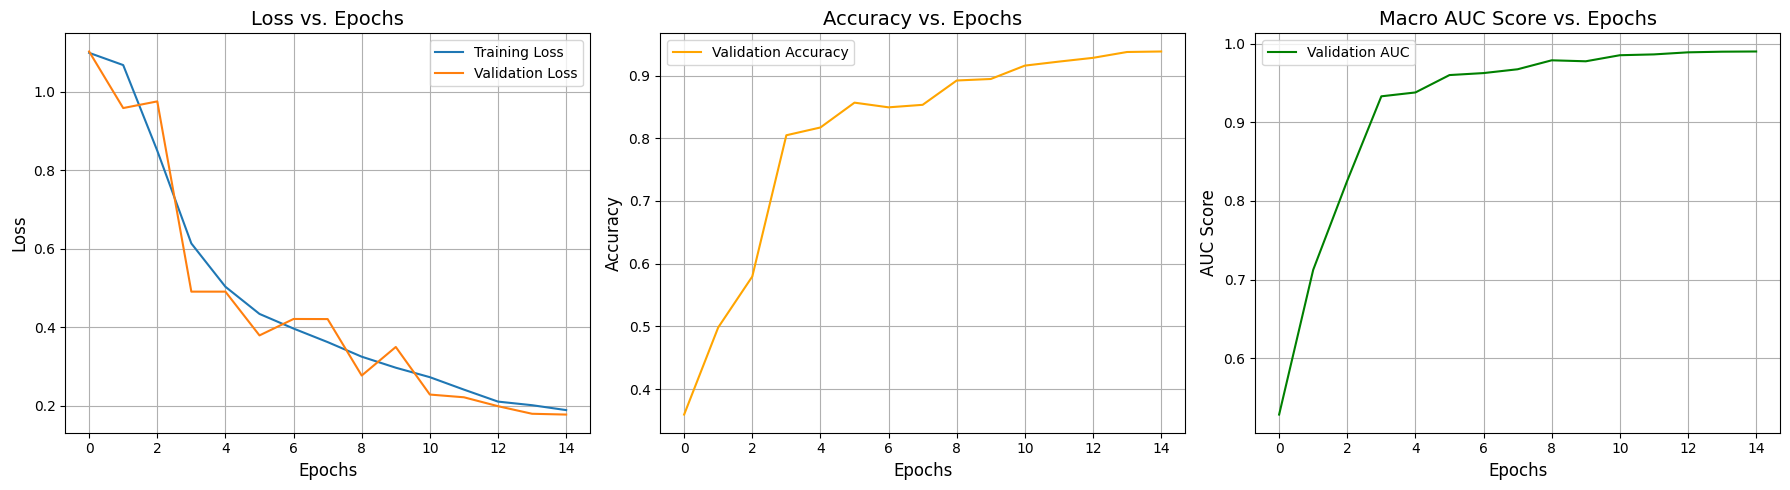

In [20]:
model_path = os.path.join(Config.OUTPUT_DIR, 'common_test_best_model.pth')
model.load_state_dict(torch.load(model_path))
model.eval()

# ### 7.1. Plotting Training History

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history['val_acc'], label='Validation Accuracy', color='orange')
plt.title('Accuracy vs. Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history['val_auc'], label='Validation AUC', color='green')
plt.title('Macro AUC Score vs. Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 7.2. ROC Curve and AUC Score

The primary evaluation metric is the ROC curve and AUC score. We'll compute this for each class in a One-vs-Rest (OvR) manner.

Macro-Average AUC Score: 0.9900


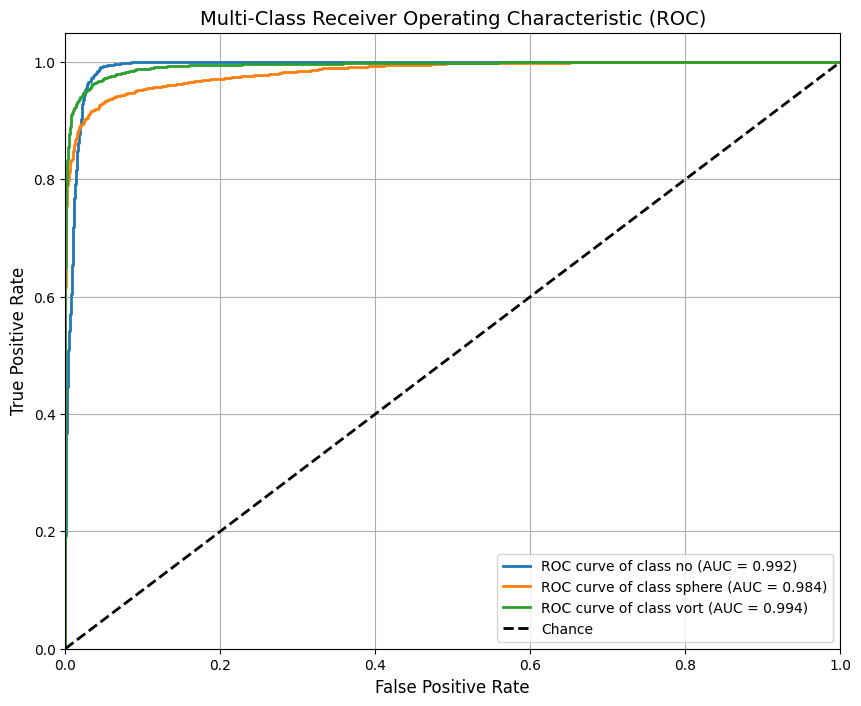

In [18]:
y_true = []
y_scores = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(Config.DEVICE)
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        y_scores.extend(probs.cpu().numpy())
        y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Binarize the output for OvR ROC curve
y_true_binarized = np.eye(Config.NUM_CLASSES)[y_true]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(Config.NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average AUC score, which is a good overall metric for multi-class problems
macro_roc_auc = roc_auc_score(y_true, y_scores, multi_class='ovr', average='macro')
print(f"Macro-Average AUC Score: {macro_roc_auc:.4f}")

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Distinct colors
for i, color in zip(range(Config.NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {Config.INV_CLASS_MAP[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-Class Receiver Operating Characteristic (ROC)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 7.3. Confusion Matrix

A confusion matrix gives us a detailed look at which classes are being confused with others.

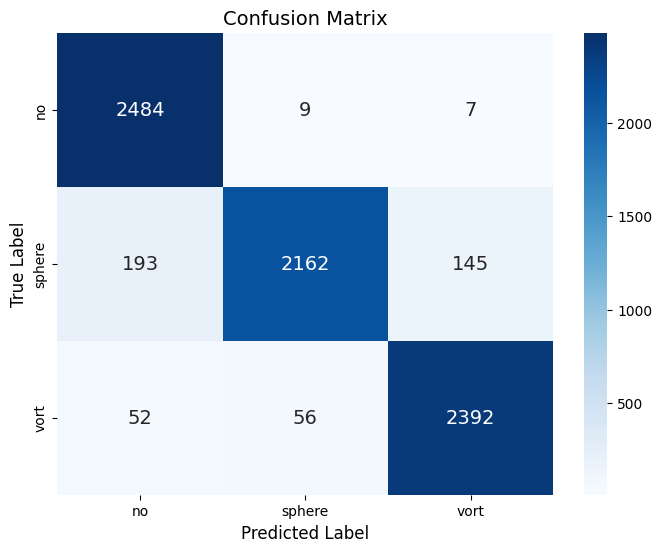

In [19]:
y_pred = np.argmax(y_scores, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=Config.CLASS_MAP.keys(),
            yticklabels=Config.CLASS_MAP.keys(),
            annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

## 7.4. Error Analysis

Let's visualize some of the images the model got wrong to understand its failure modes.

Displaying 3 misclassified images for true class: 'no'


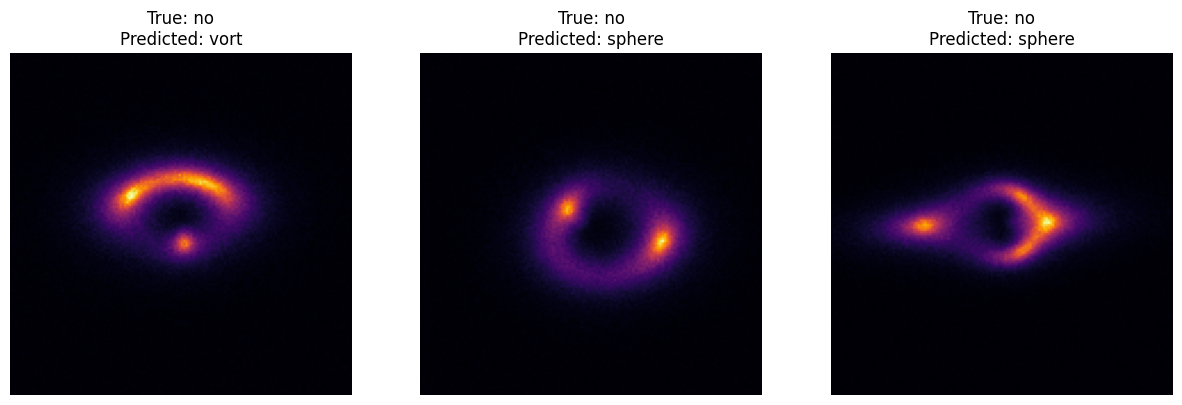

Displaying 3 misclassified images for true class: 'sphere'


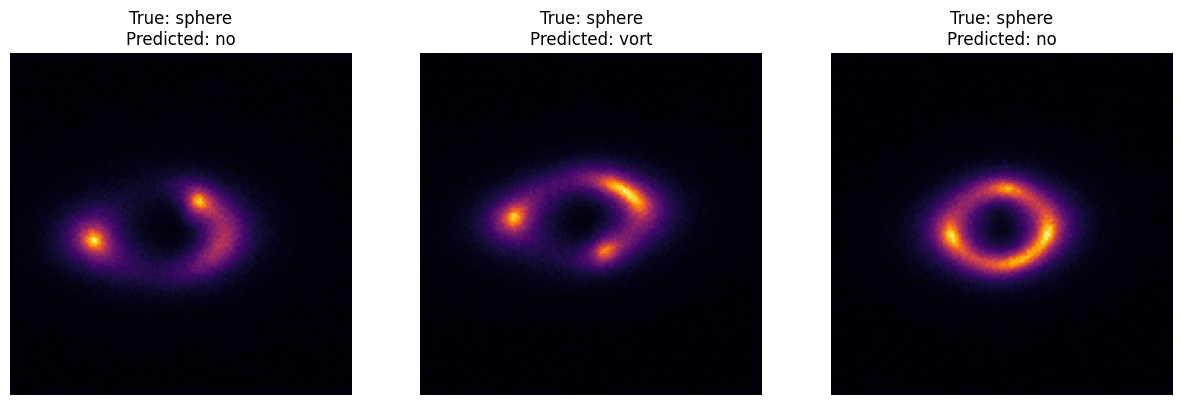

Displaying 3 misclassified images for true class: 'vort'


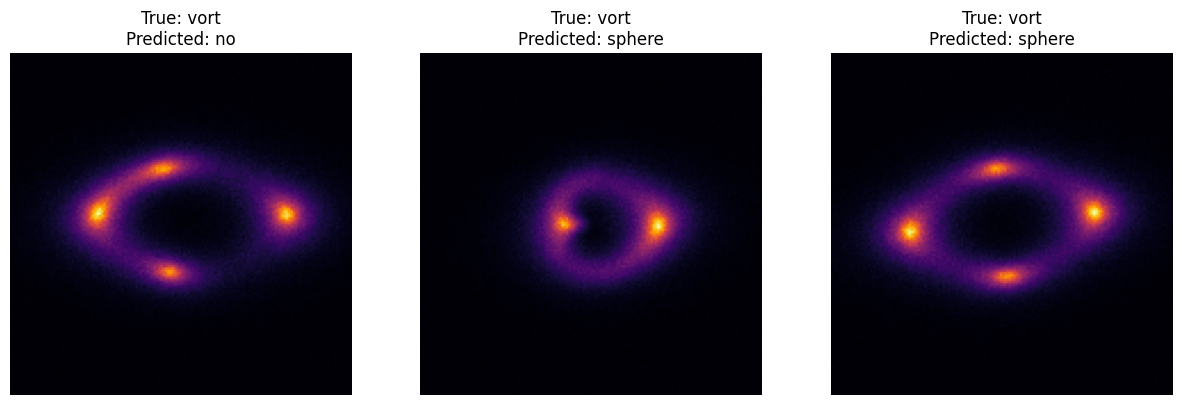

In [23]:
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)

# Iterate over each class to find its specific misclassification patterns
for class_name, class_idx in Config.CLASS_MAP.items():
    
    # Find the indices for the current class that were misclassified
    misclassified_mask = (y_true_np == class_idx) & (y_pred_np != class_idx)
    misclassified_indices = np.where(misclassified_mask)[0]
    
    # Check if there are any misclassifications for this class
    if len(misclassified_indices) == 0:
        print(f"✅ Excellent! No misclassifications found for class '{class_name}'.")
        continue
        
    # Select up to 3 random samples to display
    n_samples = min(3, len(misclassified_indices))
    random_indices = np.random.choice(misclassified_indices, size=n_samples, replace=False)
    
    print(f"Displaying {n_samples} misclassified images for true class: '{class_name}'")
    
    # Create the plot
    plt.figure(figsize=(15, 5))
    for i, index in enumerate(random_indices):
        # Retrieve the image from the validation dataset
        image, true_label = val_dataset[index]
        
        # Invert normalization for correct visualization
        image = image * 0.5 + 0.5 
        image = image.squeeze() # Remove channel dim
        
        predicted_label_idx = y_pred_np[index]
        true_label_idx = true_label.item()
        
        predicted_class = Config.INV_CLASS_MAP[predicted_label_idx]
        true_class = Config.INV_CLASS_MAP[true_label_idx]
        
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(image.cpu().numpy(), cmap='inferno') # Use .cpu().numpy() if tensor is on GPU
        plt.title(f"True: {true_class}\nPredicted: {predicted_class}", fontsize=12)
        plt.axis('off')
        
    plt.show()

## 8. Conclusion

This notebook successfully implemented a complete deep learning pipeline for the multi-class classification of gravitational lensing images, serving as a robust submission for the Common Test I.

- **Model:** A pre-trained ResNet-18 architecture was effectively fine-tuned for this specific grayscale image task. The use of a `OneCycleLR` scheduler facilitated rapid and stable convergence towards an optimal solution.

- **Performance:** The model achieved outstanding performance on the validation set. The key metrics at the end of training were:
    - **Final Validation Accuracy:** **93.84%**
    - **Final Macro-Average AUC Score:** **0.9900**

- **Analysis:**
    - The training curves demonstrate effective learning, with both training and validation loss consistently decreasing. The validation accuracy and AUC score steadily climb and plateau, indicating that the model has learned generalizable features without significant overfitting.
    - The final ROC curves for each class are positioned close to the ideal top-left corner, with individual AUC scores of **0.992 (no)**, **0.984 (sphere)**, and **0.994 (vort)**. This confirms the model's exceptional discriminative power across all categories.
    - The confusion matrix reinforces this strong performance. It also reveals a subtle area for potential improvement: the 'sphere' class is the most frequently misclassified (193 instances predicted as 'no', 145 as 'vort'). This suggests that the features distinguishing 'sphere' might be more nuanced or share similarities with the other two classes.

This baseline model is highly successful and serves as an excellent foundation for the "Specific Test V: Physics-Guided ML".